### Import Necessary Libraries

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import recall_score, roc_auc_score, accuracy_score
from scipy.stats import norm

warnings.filterwarnings('ignore')

###  Load and Explore the Dataset

In [2]:
df = pd.read_csv('Mortgage_default - hmeq.csv')
print(df.head())

   BAD  MORTDUE     VALUE     JOB   YOJ  DEROG  DELINQ       CLAGE  NINQ  \
0    1  25860.0   39025.0   Other  10.5    0.0     0.0   94.366667   1.0   
1    1  70053.0   68400.0   Other   7.0    0.0     2.0  121.833333   0.0   
2    1  13500.0   16700.0   Other   4.0    0.0     0.0  149.466667   1.0   
3    1      NaN       NaN     NaN   NaN    NaN     NaN         NaN   NaN   
4    0  97800.0  112000.0  Office   3.0    0.0     0.0   93.333333   0.0   

   CLNO  DEBTINC  
0   9.0      NaN  
1  14.0      NaN  
2  10.0      NaN  
3   NaN      NaN  
4  14.0      NaN  


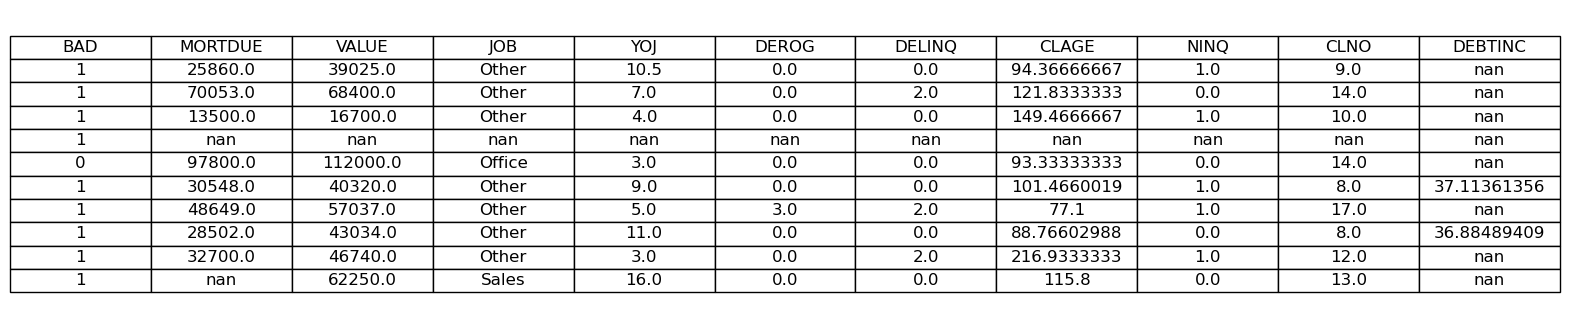

In [3]:
key_columns = df[['BAD', 'MORTDUE', 'VALUE','JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO',  'DEBTINC']]

fig, ax = plt.subplots(figsize=(8, 4))

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

table = ax.table(cellText=key_columns.head(10).values,  
                 colLabels=key_columns.columns,
                 cellLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(2.5, 1.4)  

plt.show()

### Data Preparation and Handling Missing Values

In [4]:
# Filling missing 'VALUE' with default LTV of 0.45
df['VALUE'].fillna(df['MORTDUE'] / 0.45, inplace=True)

# Filling missing numeric columns with their median
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Filling missing job categories with 'Unknown'
df['JOB'].fillna('Unknown', inplace=True)

# Checking for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 BAD        0
MORTDUE    0
VALUE      0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64


### Cleaned Dataset for analysis

In [5]:
df.head()

,BAD,MORTDUE,VALUE,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,25860.0,39025.0,Other,10.5,0.0,0.0,94.366667,1.0,9.0,34.818262
1,1,70053.0,68400.0,Other,7.0,0.0,2.0,121.833333,0.0,14.0,34.818262
2,1,13500.0,16700.0,Other,4.0,0.0,0.0,149.466667,1.0,10.0,34.818262
3,1,65019.0,89526.0,Unknown,7.0,0.0,0.0,173.466667,1.0,20.0,34.818262
4,0,97800.0,112000.0,Office,3.0,0.0,0.0,93.333333,0.0,14.0,34.818262


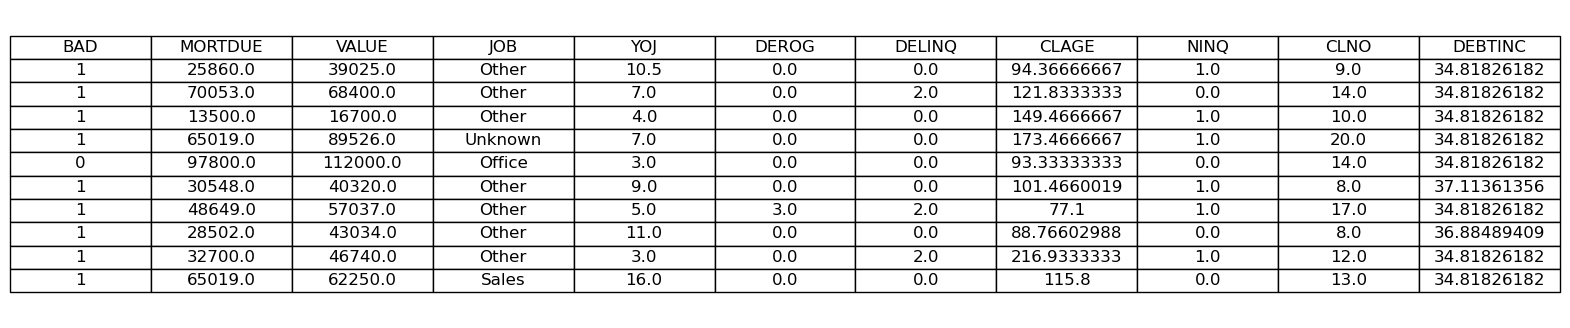

In [6]:
key_columns = df[['BAD', 'MORTDUE', 'VALUE','JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO',  'DEBTINC']]

fig, ax = plt.subplots(figsize=(8, 4))

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

table = ax.table(cellText=key_columns.head(10).values,  
                 colLabels=key_columns.columns,
                 cellLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(2.5, 1.4)  

plt.show()

### Exploratory Data Analysis

#### Summary stats

In [7]:
summary_stats = df.describe()
print(summary_stats)

               BAD        MORTDUE          VALUE          YOJ        DEROG  \
count  5960.000000    5960.000000    5960.000000  5960.000000  5960.000000   
mean      0.199497   73001.041812  102602.429444     8.756166     0.224329   
std       0.399656   42552.726779   59416.834740     7.259424     0.798458   
min       0.000000    2063.000000    8000.000000     0.000000     0.000000   
25%       0.000000   48139.000000   66259.500000     3.000000     0.000000   
50%       0.000000   65019.000000   89526.000000     7.000000     0.000000   
75%       0.000000   88200.250000  120778.000000    12.000000     0.000000   
max       1.000000  399550.000000  887888.888889    41.000000    10.000000   

            DELINQ        CLAGE         NINQ         CLNO      DEBTINC  
count  5960.000000  5960.000000  5960.000000  5960.000000  5960.000000  
mean      0.405705   179.440725     1.170134    21.247819    34.000651  
std       1.079256    83.574697     1.653866     9.951308     7.644528  
min  

#### Key Numerical Features by Default Status

Summary Statistics for Key Numerical Features by Default Status:
          MORTDUE                                 VALUE           \
             mean   median           std           mean   median   
BAD                                                                
0    73982.084391  65019.0  41751.257924  102576.744861  90599.0   
1    69064.495013  63800.0  45433.203089  102705.491804  84579.0   

                        YOJ                      DEROG  ...      CLAGE  \
              std      mean median       std      mean  ...        std   
BAD                                                     ...              
0    52712.048892  8.951687    7.0  7.332096  0.116747  ...  82.454690   
1    80943.870513  7.971615    7.0  6.907704  0.656013  ...  82.318245   

         NINQ                        CLNO                      DEBTINC  \
         mean median       std       mean median        std       mean   
BAD                                                                      
0

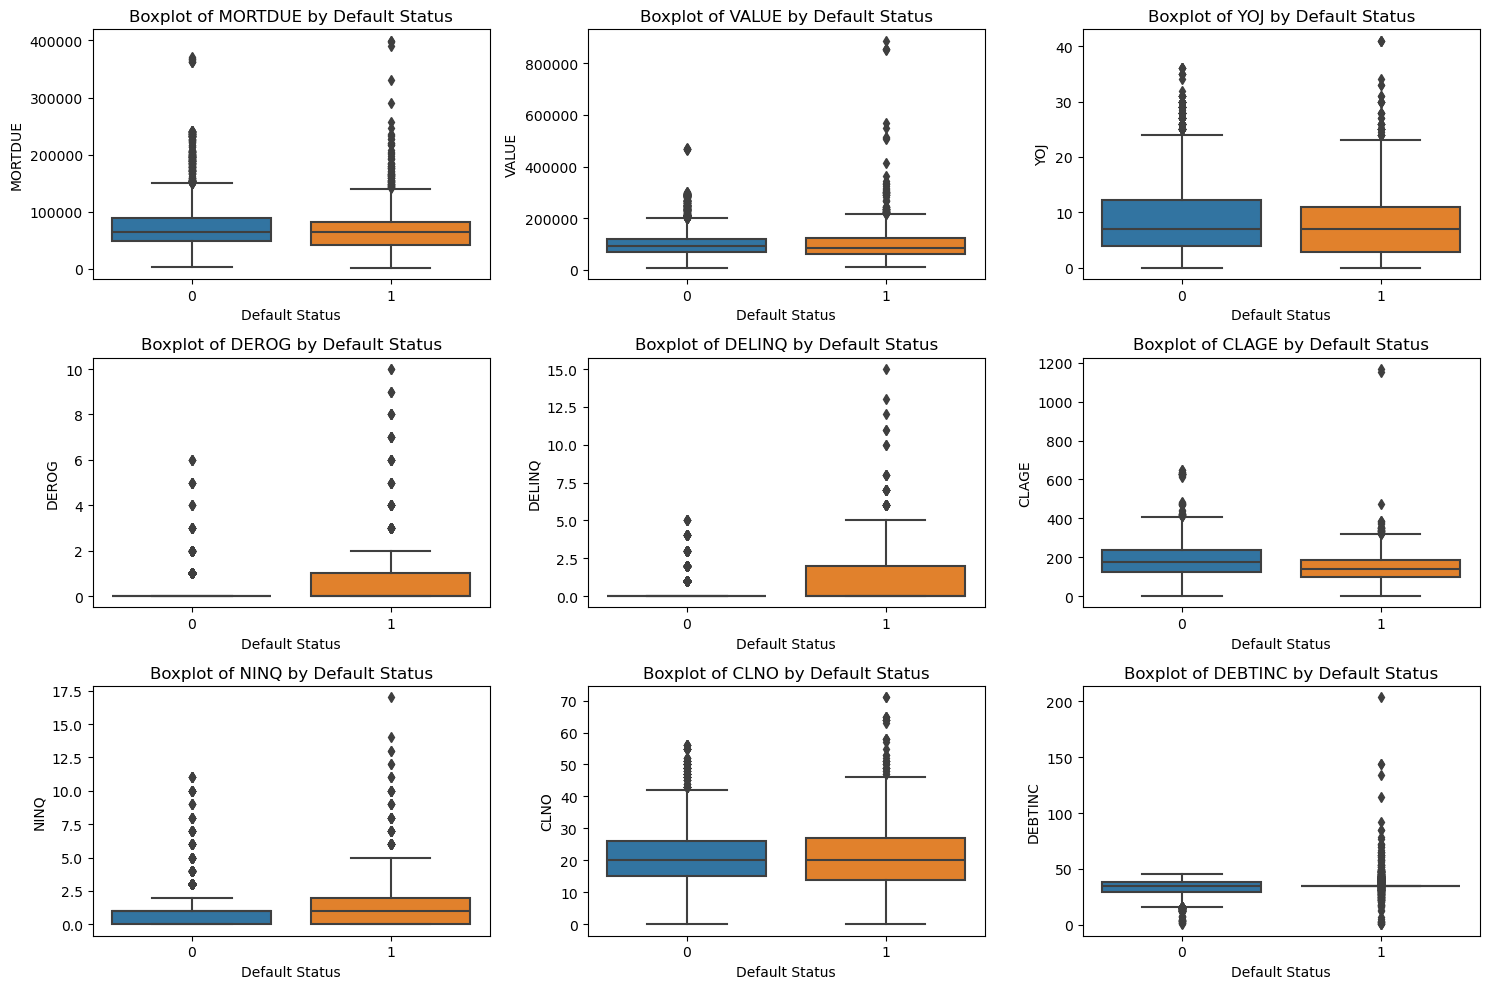

In [8]:
num_features = ['MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

summary_stats = df.groupby('BAD')[num_features].agg(['mean', 'median', 'std'])

print("Summary Statistics for Key Numerical Features by Default Status:")
print(summary_stats)

plt.figure(figsize=(15, 10))

for i, feature in enumerate(num_features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(data=df, x='BAD', y=feature)
    plt.title(f'Boxplot of {feature} by Default Status')
    plt.xlabel('Default Status')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

#### Distribution of Target Variable

Distribution of Default Status (BAD):
BAD
0    4771
1    1189
Name: count, dtype: int64


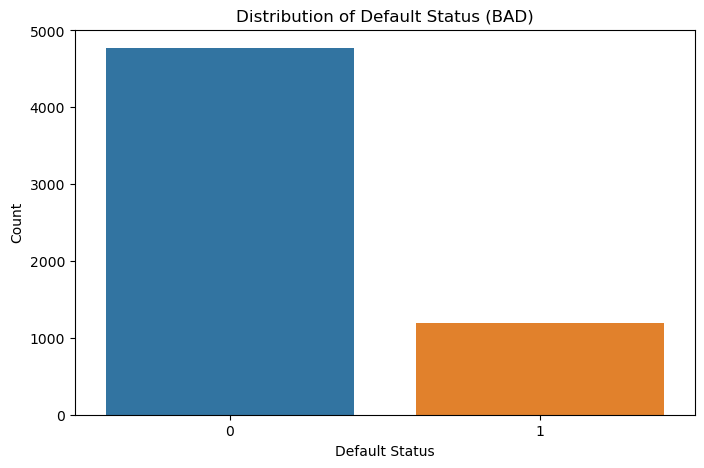

In [9]:
bad_counts = df['BAD'].value_counts()

print("Distribution of Default Status (BAD):")
print(bad_counts)

plt.figure(figsize=(8, 5))  
sns.countplot(data=df, x='BAD')
plt.title('Distribution of Default Status (BAD)')
plt.xlabel('Default Status')
plt.ylabel('Count')
plt.show()

#### Default Status by Job Type

In [10]:
job_default_counts = df.groupby(['JOB', 'BAD']).size().unstack(fill_value=0)

job_default_percentages = job_default_counts.div(job_default_counts.sum(axis=1), axis=0) * 100

print("Default Status by Job Type in Percentages:")
print(job_default_percentages)

Default Status by Job Type in Percentages:
BAD              0          1
JOB                          
Mgr      76.662321  23.337679
Office   86.814346  13.185654
Other    76.800670  23.199330
ProfExe  83.385580  16.614420
Sales    65.137615  34.862385
Self     69.948187  30.051813
Unknown  91.756272   8.243728


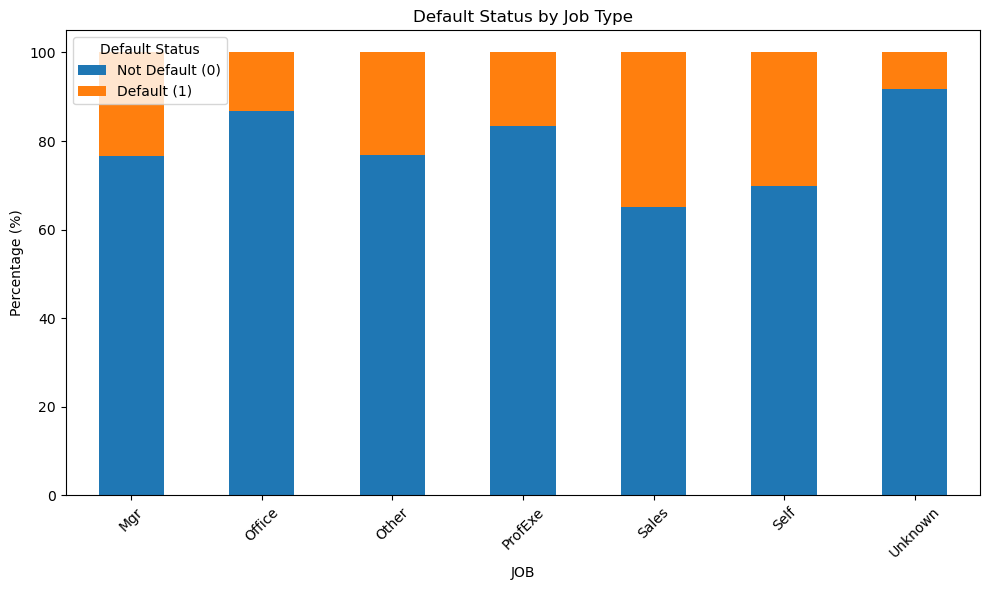

In [11]:
ax = job_default_percentages.plot(kind='bar', stacked=True, figsize=(10, 6))

ax.set_ylabel('Percentage (%)')
ax.set_title('Default Status by Job Type')
ax.set_xticklabels(job_default_percentages.index, rotation=45)
ax.legend(['Not Default (0)', 'Default (1)'], title='Default Status')

plt.tight_layout()
plt.show()

#### Correlation matrix 

In [12]:
numeric_df = df.select_dtypes(include=[np.number])

correlation_matrix = numeric_df.corr()

print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
              BAD   MORTDUE     VALUE       YOJ     DEROG    DELINQ     CLAGE  \
BAD      1.000000 -0.046186  0.000866 -0.053956  0.269921  0.346503 -0.165614   
MORTDUE -0.046186  1.000000  0.798710 -0.076201 -0.047123  0.003580  0.129799   
VALUE    0.000866  0.798710  1.000000  0.006494 -0.039065  0.026389  0.166140   
YOJ     -0.053956 -0.076201  0.006494  1.000000 -0.057729  0.051580  0.186203   
DEROG    0.269921 -0.047123 -0.039065 -0.057729  1.000000  0.171286 -0.079482   
DELINQ   0.346503  0.003580  0.026389  0.051580  0.171286  1.000000  0.026324   
CLAGE   -0.165614  0.129799  0.166140  0.186203 -0.079482  0.026324  1.000000   
NINQ     0.170031  0.032582 -0.003077 -0.062837  0.146590  0.059194 -0.109736   
CLNO    -0.004543  0.318515  0.265613  0.032815  0.052075  0.161153  0.233802   
DEBTINC  0.154544  0.134575  0.104931 -0.046482  0.020542  0.048307 -0.040741   

             NINQ      CLNO   DEBTINC  
BAD      0.170031 -0.004543  0.154544  
MORTDUE 

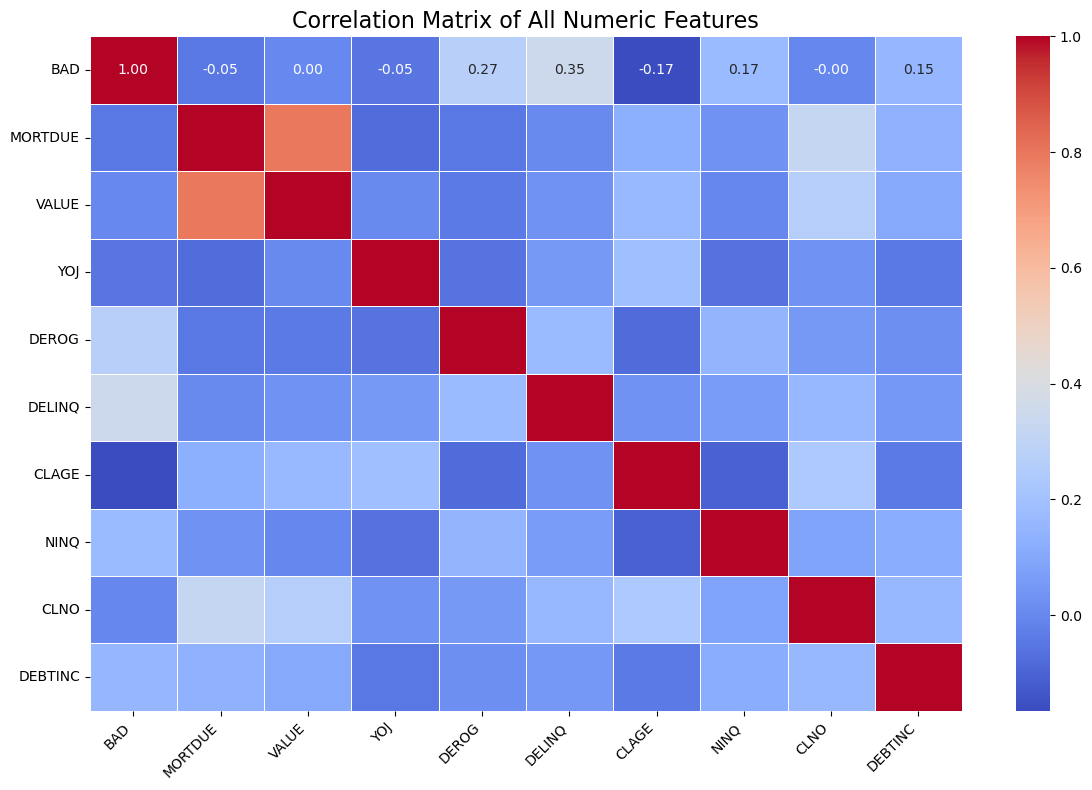

In [13]:
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Correlation Matrix of All Numeric Features', fontsize=16)
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0) 

plt.tight_layout()
plt.show()

In [14]:
correlation_mortgage_value = df['MORTDUE'].corr(df['VALUE'])
print(f'Correlation between MORTDUE and VALUE: {correlation_mortgage_value}')

Correlation between MORTDUE and VALUE: 0.7987102639311812


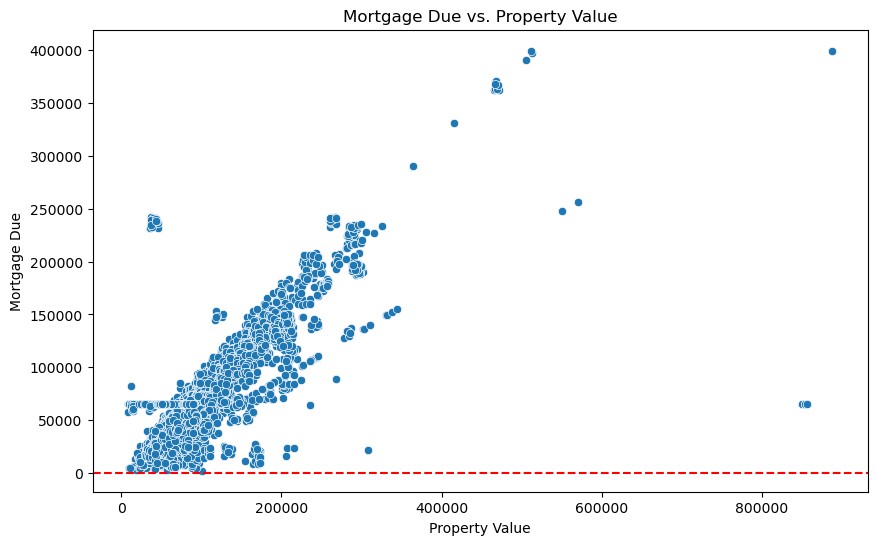

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='VALUE', y='MORTDUE', data=df)
plt.title('Mortgage Due vs. Property Value')
plt.xlabel('Property Value')
plt.ylabel('Mortgage Due')
plt.axhline(0, color='red', linestyle='--') 
plt.show()

#### Delinquency rates by job type

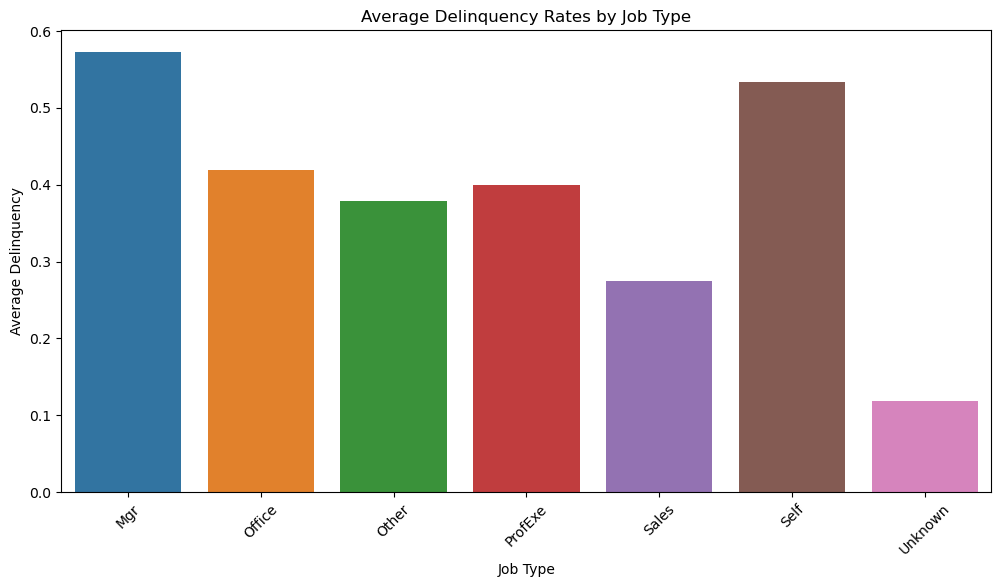

In [16]:
segment_analysis = df.groupby('JOB')['DELINQ'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='JOB', y='DELINQ', data=segment_analysis)
plt.title('Average Delinquency Rates by Job Type')
plt.xlabel('Job Type')
plt.ylabel('Average Delinquency')
plt.xticks(rotation=45)
plt.show()

### Calculating Loan-to-Value (LTV)

In [17]:
df['LTV'] = df['MORTDUE'] / df['VALUE']

### Filtering for Defaulted and Non-defaulted loans

In [18]:
non_defaulted_df = df[df['BAD'] == 0].copy()

In [19]:
defaulted_loans = df[df['BAD'] == 1]

### Standardized Approach to RWA Calculation

In [20]:
# Defining the risk weight function based on LTV
def standardized_risk_weight(LTV):
    if LTV <= 0.60:
        return 0.35
    elif LTV <= 0.80:
        return 0.50
    elif LTV <= 0.90:
        return 0.75
    else:
        return 1.0

# Calculating Standardized Risk Weights for defaulted & non-defaulted loans
non_defaulted_df['Standardized_Risk_Weight'] = non_defaulted_df['LTV'].apply(standardized_risk_weight)
defaulted_loans['Standardized_Risk_Weight'] = defaulted_loans['LTV'].apply(standardized_risk_weight)

# Calculating RWA for defaulted & non-defaulted loans
non_defaulted_df['RWA_Standardized'] = non_defaulted_df['MORTDUE'] * non_defaulted_df['Standardized_Risk_Weight']
defaulted_loans['RWA_Standardized'] = defaulted_loans['MORTDUE'] * defaulted_loans['Standardized_Risk_Weight']

In [21]:
# Updating the original DataFrame with RWA_Standardized
df = df.merge(non_defaulted_df[['MORTDUE', 'RWA_Standardized']], on='MORTDUE', how='left')

### Inspecting defaulted & non-defaulted loans DataFrame

In [22]:
print(non_defaulted_df[['MORTDUE', 'LTV', 'Standardized_Risk_Weight', 'RWA_Standardized']].head())

     MORTDUE       LTV  Standardized_Risk_Weight  RWA_Standardized
4    97800.0  0.873214                      0.75          73350.00
13   64536.0  0.738398                      0.50          32268.00
19  102370.0  0.846362                      0.75          76777.50
26   98449.0  0.840044                      0.75          73836.75
29    7229.0  0.162391                      0.35           2530.15


In [23]:
print(defaulted_loans[['MORTDUE', 'LTV', 'Standardized_Risk_Weight', 'RWA_Standardized']].head())

   MORTDUE       LTV  Standardized_Risk_Weight  RWA_Standardized
0  25860.0  0.662652                      0.50           12930.0
1  70053.0  1.024167                      1.00           70053.0
2  13500.0  0.808383                      0.75           10125.0
3  65019.0  0.726258                      0.50           32509.5
5  30548.0  0.757639                      0.50           15274.0


In [24]:
df

,BAD,MORTDUE,VALUE,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,LTV,RWA_Standardized
0,1,25860.0,39025.0,Other,10.5,0.0,0.0,94.366667,1.0,9.0,34.818262,0.662652,NaN
1,1,70053.0,68400.0,Other,7.0,0.0,2.0,121.833333,0.0,14.0,34.818262,1.024167,NaN
2,1,13500.0,16700.0,Other,4.0,0.0,0.0,149.466667,1.0,10.0,34.818262,0.808383,NaN
3,1,65019.0,89526.0,Unknown,7.0,0.0,0.0,173.466667,1.0,20.0,34.818262,0.726258,65019.00
4,1,65019.0,89526.0,Unknown,7.0,0.0,0.0,173.466667,1.0,20.0,34.818262,0.726258,48764.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219357,0,57264.0,90185.0,Other,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347,0.634961,28632.00
219358,0,54576.0,92937.0,Other,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971,0.587237,19101.60
219359,0,54045.0,92924.0,Other,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590,0.581604,18915.75
219360,0,50370.0,91861.0,Other,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882,0.548328,17629.50


### Internal Ratings-Based (IRB) Approach

#### One-hot encoding on the 'JOB' column to include it in the model

In [25]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_jobs = encoder.fit_transform(df[['JOB']])

job_encoded_df = pd.DataFrame(encoded_jobs, columns=encoder.get_feature_names_out(['JOB']))

In [26]:
df = pd.concat([df.reset_index(drop=True), job_encoded_df.reset_index(drop=True)], axis=1)

In [27]:
non_defaulted_df = pd.concat([non_defaulted_df.reset_index(drop=True), job_encoded_df.reset_index(drop=True)], axis=1)

In [28]:
defaulted_loans = pd.concat([defaulted_loans.reset_index(drop=True), job_encoded_df.reset_index(drop=True)], axis=1)

In [29]:
imputer = SimpleImputer(strategy='mean')
df[['YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']] = imputer.fit_transform(df[['YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']])

# Also, applying the imputer to non_defaulted_df to ensure no NaNs are present
non_defaulted_df[['YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']] = imputer.transform(non_defaulted_df[['YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']])

In [30]:
imputer = SimpleImputer(strategy='mean')
df[['YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']] = imputer.fit_transform(df[['YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']])

# Also, applying the imputer to defaulted_loans to ensure no NaNs are present
defaulted_loans[['YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']] = imputer.transform(defaulted_loans[['YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']])

### PD modeling with Logistic Regression

In [31]:
job_columns = list(job_encoded_df.columns)
X = df[['YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'] + job_columns]
y = df['BAD']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Calculate PD for all loans
df['PD'] = model.predict_proba(X)[:, 1]

### Evaluating the model

In [32]:
y_pred_test = model.predict(X_test)
y_proba_test = model.predict_proba(X_test)[:, 1]  

# Calculating performance metrics
recall = recall_score(y_test, y_pred_test)
auc = roc_auc_score(y_test, y_proba_test)
accuracy = accuracy_score(y_test, y_pred_test)

print(f"Recall: {recall}")
print(f"AUC: {auc}")
print(f"Accuracy: {accuracy}")

Recall: 0.4662567597599822
AUC: 0.8881484151371042
Accuracy: 0.8722971022200611


### Calculating RWA Under the IRB Approach

In [33]:
# LGD is 45%
LGD = 0.45

# Calculating RWA under the IRB approach
df['RWA_IRB'] = df['PD'] * LGD * df['MORTDUE'] * 12.5
df['RWA_IRB']

0          47100.368094
1         358971.564719
2          18645.284037
3          71865.540370
4          71865.540370
              ...      
219357     41301.179812
219358     41093.968484
219359     38367.715186
219360     30887.791293
219361     29303.123234
Name: RWA_IRB, Length: 219362, dtype: float64

### Handling Defaulted Loans

In [34]:
# Function to calculate RWA for defaulted loans, considering expected loss
def calculate_rwa_for_defaulted(LGD, expected_loss, EAD):
    K = max(0, LGD - expected_loss)  
    return K * 12.5 * EAD

# Calculate expected loss
expected_loss = df['DELINQ'].mean() * 1.5  

# Calculate RWA for defaulted loans
defaulted_loans['RWA_Defaulted'] = defaulted_loans.apply(
    lambda row: calculate_rwa_for_defaulted(LGD=0.45, expected_loss=expected_loss, EAD=row['MORTDUE']), axis=1
)

# Update the original df with the RWA results for defaulted loans
df.loc[df['BAD'] == 1, 'RWA_Defaulted'] = defaulted_loans['RWA_Defaulted']

# Print the RWA results for defaulted loans
print("RWA Results for Defaulted Loans:")
print(defaulted_loans[['MORTDUE', 'DELINQ', 'RWA_Defaulted']])

RWA Results for Defaulted Loans:
        MORTDUE    DELINQ  RWA_Defaulted
0       25860.0  0.000000   35029.335300
1       70053.0  2.000000   94892.112364
2       13500.0  0.000000   18286.775968
3       65019.0  0.000000   88073.176792
4       30548.0  0.000000   41379.587577
...         ...       ...            ...
219357      NaN  0.227756            NaN
219358      NaN  0.227756            NaN
219359      NaN  0.227756            NaN
219360      NaN  0.227756            NaN
219361      NaN  0.227756            NaN

[219362 rows x 3 columns]


### Effective Maturity Calculation

In [35]:
# Add Maturity to the DataFrame 
df['Maturity'] = 2.5

non_defaulted_df['Maturity'] = 2.5
defaulted_loans['Maturity'] = 2.5

In [36]:
print(non_defaulted_df.columns)

Index(['BAD', 'MORTDUE', 'VALUE', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC', 'LTV', 'Standardized_Risk_Weight',
       'RWA_Standardized', 'JOB_Office', 'JOB_Other', 'JOB_ProfExe',
       'JOB_Sales', 'JOB_Self', 'JOB_Unknown', 'Maturity'],
      dtype='object')


In [37]:
print(defaulted_loans.columns)

Index(['BAD', 'MORTDUE', 'VALUE', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC', 'LTV', 'Standardized_Risk_Weight',
       'RWA_Standardized', 'JOB_Office', 'JOB_Other', 'JOB_ProfExe',
       'JOB_Sales', 'JOB_Self', 'JOB_Unknown', 'RWA_Defaulted', 'Maturity'],
      dtype='object')


In [38]:
# Calculating RWA using maturity for all loans
def calculate_rwa_with_maturity(PD, LGD, EAD, M):
    b = (0.11852 - 0.05478 * np.log(PD)) ** 2
    capital_requirement = PD * LGD * (1 + (M - 2.5) * b) / (1 - 1.5 * b)
    return capital_requirement * EAD * 12.5

# Calculating RWA with Maturity for non-defaulted loans
df['RWA_IRB_with_M'] = df.apply(
    lambda row: calculate_rwa_with_maturity(PD=row['PD'], LGD=0.45, EAD=row['MORTDUE'], M=row['Maturity']), axis=1)

In [39]:
# Filter for defaulted loans
defaulted_loans = df[df['BAD'] == 1].copy()

# Calculating RWA with Maturity for defaulted loans
defaulted_loans['RWA_IRB_with_M'] = defaulted_loans.apply(
    lambda row: calculate_rwa_with_maturity(PD=row['PD'], LGD=0.45, EAD=row['MORTDUE'], M=row['Maturity']), axis=1)

In [40]:
# Filter for non-defaulted loans
non_defaulted_df = df[df['BAD'] == 0].copy()

# Calculate RWA with Maturity for non-defaulted loans
non_defaulted_df['RWA_IRB_with_M'] = non_defaulted_df.apply(
    lambda row: calculate_rwa_with_maturity(PD=row['PD'], LGD=0.45, EAD=row['MORTDUE'], M=row['Maturity']), axis=1)

In [41]:
print(non_defaulted_df[['MORTDUE', 'RWA_IRB_with_M']].head())

       MORTDUE  RWA_IRB_with_M
415    97800.0    35958.818834
836    64536.0    53078.482613
844   102370.0    24162.908330
1262   98449.0    17085.969886
1265    7229.0     4923.649243


In [42]:
# Checking the calculated RWA_IRB_with_M
print(defaulted_loans[['MORTDUE', 'RWA_IRB_with_M']].head())

   MORTDUE  RWA_IRB_with_M
0  25860.0    49514.590518
1  70053.0   367394.262513
2  13500.0    19778.601419
3  65019.0    76835.201874
4  65019.0    76835.201874


In [43]:
# Updating the original DataFrame with RWA_IRB_with_M
df['RWA_IRB_with_M'] = non_defaulted_df['RWA_IRB_with_M']

In [44]:
# RWA calculation under the IRB Approach with maturity adjustment
def calculate_rwa_with_maturity(PD, LGD, EAD, M):
    # Correlation factor based on PD
    b = (0.11852 - 0.05478 * np.log(PD)) ** 2
    capital_requirement = PD * LGD * (1 + (M - 2.5) * b) / (1 - 1.5 * b)
    return capital_requirement * EAD * 12.5

In [45]:
# Calculating RWA using maturity for non-defaulted loans
non_defaulted_df['RWA_IRB_with_M'] = non_defaulted_df.apply(
    lambda row: calculate_rwa_with_maturity(PD=row['PD'], LGD=0.45, EAD=row['MORTDUE'], M=row['Maturity']), axis=1
)

In [46]:
# Calculating RWA using maturity for defaulted loans
defaulted_loans['RWA_IRB_with_M'] = defaulted_loans.apply(
    lambda row: calculate_rwa_with_maturity(PD=row['PD'], LGD=0.45, EAD=row['MORTDUE'], M=row['Maturity']), axis=1
)

In [47]:
df

,BAD,MORTDUE,VALUE,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,...,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,JOB_Unknown,PD,RWA_IRB,RWA_Defaulted,Maturity,RWA_IRB_with_M
0,1,25860.0,39025.0,Other,10.5,0.0,0.0,94.366667,1.0,9.0,...,1.0,0.0,0.0,0.0,0.0,0.323797,47100.368094,35029.335300,2.5,NaN
1,1,70053.0,68400.0,Other,7.0,0.0,2.0,121.833333,0.0,14.0,...,1.0,0.0,0.0,0.0,0.0,0.910984,358971.564719,94892.112364,2.5,NaN
2,1,13500.0,16700.0,Other,4.0,0.0,0.0,149.466667,1.0,10.0,...,1.0,0.0,0.0,0.0,0.0,0.245535,18645.284037,18286.775968,2.5,NaN
3,1,65019.0,89526.0,Unknown,7.0,0.0,0.0,173.466667,1.0,20.0,...,0.0,0.0,0.0,0.0,1.0,0.196498,71865.540370,88073.176792,2.5,NaN
4,1,65019.0,89526.0,Unknown,7.0,0.0,0.0,173.466667,1.0,20.0,...,0.0,0.0,0.0,0.0,1.0,0.196498,71865.540370,41379.587577,2.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219357,0,57264.0,90185.0,Other,16.0,0.0,0.0,221.808718,0.0,16.0,...,1.0,0.0,0.0,0.0,0.0,0.128221,41301.179812,NaN,2.5,44895.904981
219358,0,54576.0,92937.0,Other,16.0,0.0,0.0,208.692070,0.0,15.0,...,1.0,0.0,0.0,0.0,0.0,0.133861,41093.968484,NaN,2.5,44591.834374
219359,0,54045.0,92924.0,Other,15.0,0.0,0.0,212.279697,0.0,15.0,...,1.0,0.0,0.0,0.0,0.0,0.126208,38367.715186,NaN,2.5,41734.421554
219360,0,50370.0,91861.0,Other,14.0,0.0,0.0,213.892709,0.0,16.0,...,1.0,0.0,0.0,0.0,0.0,0.109017,30887.791293,NaN,2.5,33806.920099


### Advanced Basel RWA Calculation (with ln, N(x), G(z))

In [48]:
# Defining the normal cumulative distribution function N(x)
def N(x):
    return norm.cdf(x)

# Defining the inverse of the cumulative distribution function G(z)
def G(z):
    return norm.ppf(z)

# Basel Advanced RWA calculation function
def calculate_rwa_basel(PD, LGD, EAD):
    R = 0.12 * (1 - np.exp(-50 * PD)) / (1 - np.exp(-50))

    b = (0.11852 - 0.05478 * np.log(PD)) ** 2

    K = N((1 / np.sqrt(1 - R)) * (G(PD) + np.sqrt(R / (1 - R)) * G(0.999)))

    rwa = LGD * K * EAD * 12.5
    return rwa

In [49]:
# Applying the advanced Basel RWA calculation to each row
df['RWA_Basel_Advanced'] = df.apply(
    lambda row: calculate_rwa_basel(PD=row['PD'], LGD=0.45, EAD=row['MORTDUE']), axis=1)

In [50]:
df[['PD', 'MORTDUE', 'RWA_Basel_Advanced']].head()

,PD,MORTDUE,RWA_Basel_Advanced
0,0.323797,25860.0,111577.912239
1,0.910984,70053.0,392472.537627
2,0.245535,13500.0,52035.348993
3,0.196498,65019.0,226804.864518
4,0.196498,65019.0,226804.864518


In [51]:
# Applying the advanced Basel RWA calculation to non defaulted row
non_defaulted_df['RWA_Basel_Advanced'] = non_defaulted_df.apply(
    lambda row: calculate_rwa_basel(PD=row['PD'], LGD=0.45, EAD=row['MORTDUE']), axis=1)

In [52]:
# Applying the advanced Basel RWA calculation to defaulted row
defaulted_loans['RWA_Basel_Advanced'] = defaulted_loans.apply(
    lambda row: calculate_rwa_basel(PD=row['PD'], LGD=0.45, EAD=row['MORTDUE']), axis=1)

In [53]:
non_defaulted_df[['PD', 'MORTDUE', 'RWA_Basel_Advanced']].head()

,PD,MORTDUE,RWA_Basel_Advanced
415,0.057976,97800.0,170543.160904
836,0.134784,64536.0,187112.494414
844,0.036290,102370.0,121280.865487
1262,0.026171,98449.0,84026.000137
1265,0.110702,7229.0,18877.483196


In [54]:
defaulted_loans[['PD', 'MORTDUE', 'RWA_Basel_Advanced']].head()

,PD,MORTDUE,RWA_Basel_Advanced
0,0.323797,25860.0,111577.912239
1,0.910984,70053.0,392472.537627
2,0.245535,13500.0,52035.348993
3,0.196498,65019.0,226804.864518
4,0.196498,65019.0,226804.864518


### Capital Requirement Calculation

In [55]:
df.columns

Index(['BAD', 'MORTDUE', 'VALUE', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC', 'LTV', 'RWA_Standardized', 'JOB_Office',
       'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self', 'JOB_Unknown',
       'PD', 'RWA_IRB', 'RWA_Defaulted', 'Maturity', 'RWA_IRB_with_M',
       'RWA_Basel_Advanced'],
      dtype='object')

In [56]:
# Calculate capital requirements for each approach
df['Capital_Standardized'] = df['RWA_Standardized'] * 0.08
df['Capital_IRB'] = df['RWA_IRB'] * 0.08
df['Capital_IRB_with_M'] = df['RWA_IRB_with_M'] * 0.08
df['Capital_Basel_Advanced'] = df['RWA_Basel_Advanced'] * 0.08

# Print the DataFrame to check the new capital requirement columns
print(df[['Capital_Standardized', 'Capital_IRB', 'Capital_IRB_with_M', 'Capital_Basel_Advanced']].head())

   Capital_Standardized   Capital_IRB  Capital_IRB_with_M  \
0                   NaN   3768.029447                 NaN   
1                   NaN  28717.725177                 NaN   
2                   NaN   1491.622723                 NaN   
3               5201.52   5749.243230                 NaN   
4               3901.14   5749.243230                 NaN   

   Capital_Basel_Advanced  
0             8926.232979  
1            31397.803010  
2             4162.827919  
3            18144.389161  
4            18144.389161  


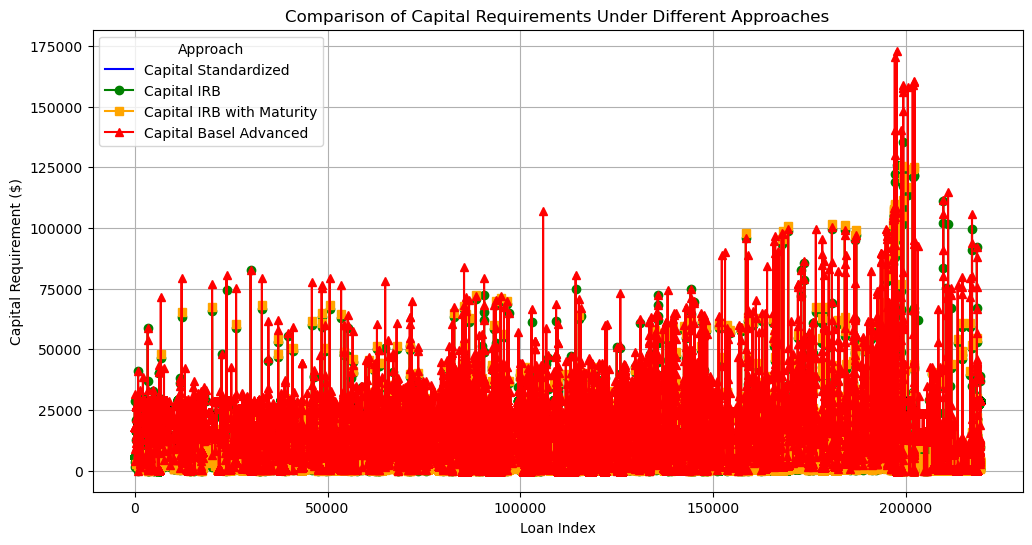

In [57]:
# Visualizations comparing the capital requirements under each approach
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Capital_Standardized'], label='Capital Standardized', color='blue')
plt.plot(df.index, df['Capital_IRB'], label='Capital IRB', color='green', marker='o')
plt.plot(df.index, df['Capital_IRB_with_M'], label='Capital IRB with Maturity', color='orange', marker='s')
plt.plot(df.index, df['Capital_Basel_Advanced'], label='Capital Basel Advanced', color='red', marker='^')
plt.title('Comparison of Capital Requirements Under Different Approaches')
plt.xlabel('Loan Index')
plt.ylabel('Capital Requirement ($)')
plt.legend(title='Approach')
plt.grid(True)
plt.show()

In [58]:
df

,BAD,MORTDUE,VALUE,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,...,PD,RWA_IRB,RWA_Defaulted,Maturity,RWA_IRB_with_M,RWA_Basel_Advanced,Capital_Standardized,Capital_IRB,Capital_IRB_with_M,Capital_Basel_Advanced
0,1,25860.0,39025.0,Other,10.5,0.0,0.0,94.366667,1.0,9.0,...,0.323797,47100.368094,35029.335300,2.5,NaN,111577.912239,NaN,3768.029447,NaN,8926.232979
1,1,70053.0,68400.0,Other,7.0,0.0,2.0,121.833333,0.0,14.0,...,0.910984,358971.564719,94892.112364,2.5,NaN,392472.537627,NaN,28717.725177,NaN,31397.803010
2,1,13500.0,16700.0,Other,4.0,0.0,0.0,149.466667,1.0,10.0,...,0.245535,18645.284037,18286.775968,2.5,NaN,52035.348993,NaN,1491.622723,NaN,4162.827919
3,1,65019.0,89526.0,Unknown,7.0,0.0,0.0,173.466667,1.0,20.0,...,0.196498,71865.540370,88073.176792,2.5,NaN,226804.864518,5201.520,5749.243230,NaN,18144.389161
4,1,65019.0,89526.0,Unknown,7.0,0.0,0.0,173.466667,1.0,20.0,...,0.196498,71865.540370,41379.587577,2.5,NaN,226804.864518,3901.140,5749.243230,NaN,18144.389161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219357,0,57264.0,90185.0,Other,16.0,0.0,0.0,221.808718,0.0,16.0,...,0.128221,41301.179812,NaN,2.5,44895.904981,161772.170302,2290.560,3304.094385,3591.672398,12941.773624
219358,0,54576.0,92937.0,Other,16.0,0.0,0.0,208.692070,0.0,15.0,...,0.133861,41093.968484,NaN,2.5,44591.834374,157673.678429,1528.128,3287.517479,3567.346750,12613.894274
219359,0,54045.0,92924.0,Other,15.0,0.0,0.0,212.279697,0.0,15.0,...,0.126208,38367.715186,NaN,2.5,41734.421554,151415.448213,1513.260,3069.417215,3338.753724,12113.235857
219360,0,50370.0,91861.0,Other,14.0,0.0,0.0,213.892709,0.0,16.0,...,0.109017,30887.791293,NaN,2.5,33806.920099,130431.421353,1410.360,2471.023303,2704.553608,10434.513708


### Total Capital Requirement (Standardized and IRB)

In [59]:
# Calculate capital requirements for each non-defaulted approach
non_defaulted_df['Capital_Standardized'] = non_defaulted_df['RWA_Standardized'] * 0.08
non_defaulted_df['Capital_IRB'] = non_defaulted_df['RWA_IRB'] * 0.08
non_defaulted_df['Capital_Basel_Advanced'] = non_defaulted_df['RWA_Basel_Advanced'] * 0.08
non_defaulted_df['Capital_IRB_with_M'] = non_defaulted_df['RWA_IRB_with_M'] * 0.08

In [60]:
# Calculate capital requirements for each defaulted approach
defaulted_loans['Capital_Standardized'] = defaulted_loans['RWA_Standardized'] * 0.08
defaulted_loans['Capital_IRB'] = defaulted_loans['RWA_IRB'] * 0.08
defaulted_loans['Capital_Basel_Advanced'] = defaulted_loans['RWA_Basel_Advanced'] * 0.08
defaulted_loans['Capital_IRB_with_M'] = defaulted_loans['RWA_IRB_with_M'] * 0.08

In [61]:
print(non_defaulted_df.columns)

if 'Capital_Standardized' in non_defaulted_df.columns and 'Capital_IRB' in non_defaulted_df.columns:
    # Now you can sum the capital requirements
    total_capital_standardized = non_defaulted_df['Capital_Standardized'].sum()
    total_capital_irb = non_defaulted_df['Capital_IRB'].sum()

    print(f"Total Capital Requirement under Standardized Approach: ${total_capital_standardized:,.2f}")
    print(f"Total Capital Requirement under IRB Approach: ${total_capital_irb:,.2f}")
else:
    print("Capital columns not found. Please check calculations.")

Index(['BAD', 'MORTDUE', 'VALUE', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC', 'LTV', 'RWA_Standardized', 'JOB_Office',
       'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self', 'JOB_Unknown',
       'PD', 'RWA_IRB', 'RWA_Defaulted', 'Maturity', 'RWA_IRB_with_M',
       'RWA_Basel_Advanced', 'Capital_Standardized', 'Capital_IRB',
       'Capital_Basel_Advanced', 'Capital_IRB_with_M'],
      dtype='object')
Total Capital Requirement under Standardized Approach: $786,321,459.46
Total Capital Requirement under IRB Approach: $627,963,132.11


In [62]:
print(defaulted_loans.columns)

if 'Capital_Standardized' in defaulted_loans.columns and 'Capital_IRB' in defaulted_loans.columns:
    # Now you can sum the capital requirements
    total_capital_standardized = defaulted_loans['Capital_Standardized'].sum()
    total_capital_irb = defaulted_loans['Capital_IRB'].sum()

    print(f"Total Capital Requirement under Standardized Approach: ${total_capital_standardized:,.2f}")
    print(f"Total Capital Requirement under IRB Approach: ${total_capital_irb:,.2f}")
else:
    print("Capital columns not found. Please check calculations.")

Index(['BAD', 'MORTDUE', 'VALUE', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC', 'LTV', 'RWA_Standardized', 'JOB_Office',
       'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self', 'JOB_Unknown',
       'PD', 'RWA_IRB', 'RWA_Defaulted', 'Maturity', 'RWA_IRB_with_M',
       'RWA_Basel_Advanced', 'Capital_Standardized', 'Capital_IRB',
       'Capital_Basel_Advanced', 'Capital_IRB_with_M'],
      dtype='object')
Total Capital Requirement under Standardized Approach: $199,237,824.69
Total Capital Requirement under IRB Approach: $696,704,342.27


In [63]:
defaulted_loans['RWA_IRB'] = defaulted_loans['PD'] * 0.45 * defaulted_loans['MORTDUE'] * 12.5
defaulted_loans['RWA_IRB']

0          47100.368094
1         358971.564719
2          18645.284037
3          71865.540370
4          71865.540370
              ...      
219332    356715.309860
219333    356715.309860
219334     54642.260209
219335    461985.873010
219336    488836.505555
Name: RWA_IRB, Length: 44915, dtype: float64

In [64]:
non_defaulted_df['RWA_IRB'] = non_defaulted_df['PD'] * 0.45 * non_defaulted_df['MORTDUE'] * 12.5
non_defaulted_df['RWA_IRB']

415       31894.012057
836       48928.604741
844       20896.955582
1262      14492.810074
1265       4501.479387
              ...     
219357    41301.179812
219358    41093.968484
219359    38367.715186
219360    30887.791293
219361    29303.123234
Name: RWA_IRB, Length: 174447, dtype: float64

In [65]:
non_defaulted_df['Capital_Standardized'] = non_defaulted_df['RWA_Standardized'] * 0.08
non_defaulted_df['Capital_IRB'] = non_defaulted_df['RWA_IRB'] * 0.08

### Overall loans

In [66]:
total_capital_standardized = df['Capital_Standardized'].sum()
total_capital_irb = df['Capital_IRB'].sum()
total_capital_basel_advanced = df['Capital_Basel_Advanced'].sum()
total_capital_irb_with_m = df['Capital_IRB_with_M'].sum()

print(f"Total Capital Requirement under Standardized Approach: ${total_capital_standardized:,.2f}")
print(f"Total Capital Requirement under IRB Approach: ${total_capital_irb:,.2f}")
print(f"Total Capital Requirement under Basel Advanced Approach: ${total_capital_basel_advanced:,.2f}")
print(f"Total Capital Requirement under IRB_With_M Approach: ${total_capital_irb_with_m:,.2f}")

Total Capital Requirement under Standardized Approach: $985,559,284.15
Total Capital Requirement under IRB Approach: $1,324,667,474.38
Total Capital Requirement under Basel Advanced Approach: $2,978,464,644.06
Total Capital Requirement under IRB_With_M Approach: $673,003,992.83


### Non-defaulted Loans

In [67]:
total_capital_standardized = non_defaulted_df['Capital_Standardized'].sum()
total_capital_irb = non_defaulted_df['Capital_IRB'].sum()
total_capital_basel_advanced = non_defaulted_df['Capital_Basel_Advanced'].sum()
total_capital_irb_with_m = non_defaulted_df['Capital_IRB_with_M'].sum()

print(f"Total Capital Requirement under Standardized Approach: ${total_capital_standardized:,.2f}")
print(f"Total Capital Requirement under IRB Approach: ${total_capital_irb:,.2f}")
print(f"Total Capital Requirement under Basel Advanced Approach: ${total_capital_basel_advanced:,.2f}")
print(f"Total Capital Requirement under IRB_With_M Approach: ${total_capital_irb:,.2f}")

Total Capital Requirement under Standardized Approach: $786,321,459.46
Total Capital Requirement under IRB Approach: $627,963,132.11
Total Capital Requirement under Basel Advanced Approach: $1,924,706,295.03
Total Capital Requirement under IRB_With_M Approach: $627,963,132.11


In [68]:
rwa_standardized = 786_321_459.46  
rwa_irb = 627_963_132.11           
rwa_basel_advanced = 1_924_706_295.03  

# Basel III Capital charge (8%)
capital_charge = 0.08

# Calculate the capital requirements
capital_standardized = rwa_standardized * capital_charge
capital_irb = rwa_irb * capital_charge
capital_basel_advanced = rwa_basel_advanced * capital_charge

# Output the calculated capital requirements
print(f"Standardized Capital Requirement: ${capital_standardized:,.2f}")
print(f"IRB Capital Requirement: ${capital_irb:,.2f}")
print(f"Basel Advanced Capital Requirement: ${capital_basel_advanced:,.2f}")

# If you want to store the results in the DataFrame, you can create new columns:
df['Capital_Standardized'] = df['RWA_Standardized'] * capital_charge
df['Capital_IRB'] = df['RWA_IRB'] * capital_charge
df['Capital_Basel_Advanced'] = df['RWA_Basel_Advanced'] * capital_charge

# Display the first few rows with the new capital requirement columns
df[['Capital_Standardized', 'Capital_IRB', 'Capital_Basel_Advanced']].head()

Standardized Capital Requirement: $62,905,716.76
IRB Capital Requirement: $50,237,050.57
Basel Advanced Capital Requirement: $153,976,503.60


,Capital_Standardized,Capital_IRB,Capital_Basel_Advanced
0,NaN,3768.029447,8926.232979
1,NaN,28717.725177,31397.803010
2,NaN,1491.622723,4162.827919
3,5201.52,5749.243230,18144.389161
4,3901.14,5749.243230,18144.389161


### Defaulted Loans

In [69]:
total_capital_standardized = defaulted_loans['Capital_Standardized'].sum()
total_capital_irb = defaulted_loans['Capital_IRB'].sum()
total_capital_basel_advanced = defaulted_loans['Capital_Basel_Advanced'].sum()
total_capital_irb_with_m = defaulted_loans['Capital_IRB_with_M'].sum()

print(f"Total Capital Requirement under Standardized Approach: ${total_capital_standardized:,.2f}")
print(f"Total Capital Requirement under IRB Approach: ${total_capital_irb:,.2f}")
print(f"Total Capital Requirement under Basel Advanced Approach: ${total_capital_basel_advanced:,.2f}")
print(f"Total Capital Requirement under IRB_With_M Approach: ${total_capital_irb:,.2f}")

Total Capital Requirement under Standardized Approach: $199,237,824.69
Total Capital Requirement under IRB Approach: $696,704,342.27
Total Capital Requirement under Basel Advanced Approach: $1,053,758,349.03
Total Capital Requirement under IRB_With_M Approach: $696,704,342.27


In [70]:
rwa_standardized = 199_237_824.69
rwa_irb = 696_704_342.27          
rwa_basel_advanced = 1_053_758_349.03

# Basel III Capital charge (8%)
capital_charge = 0.08

# Calculate the capital requirements
capital_standardized = rwa_standardized * capital_charge
capital_irb = rwa_irb * capital_charge
capital_basel_advanced = rwa_basel_advanced * capital_charge

# Output the calculated capital requirements
print(f"Standardized Capital Requirement: ${capital_standardized:,.2f}")
print(f"IRB Capital Requirement: ${capital_irb:,.2f}")
print(f"Basel Advanced Capital Requirement: ${capital_basel_advanced:,.2f}")

# If you want to store the results in the DataFrame, you can create new columns:
df['Capital_Standardized'] = df['RWA_Standardized'] * capital_charge
df['Capital_IRB'] = df['RWA_IRB'] * capital_charge
df['Capital_Basel_Advanced'] = df['RWA_Basel_Advanced'] * capital_charge

# Display the first few rows with the new capital requirement columns
df[['Capital_Standardized', 'Capital_IRB', 'Capital_Basel_Advanced']].head()

Standardized Capital Requirement: $15,939,025.98
IRB Capital Requirement: $55,736,347.38
Basel Advanced Capital Requirement: $84,300,667.92


,Capital_Standardized,Capital_IRB,Capital_Basel_Advanced
0,NaN,3768.029447,8926.232979
1,NaN,28717.725177,31397.803010
2,NaN,1491.622723,4162.827919
3,5201.52,5749.243230,18144.389161
4,3901.14,5749.243230,18144.389161


In [71]:
rwa_stats = defaulted_loans[['RWA_Standardized', 'RWA_IRB']].describe()

# Display the statistics
print(rwa_stats)

       RWA_Standardized       RWA_IRB
count      44050.000000  4.491500e+04
mean       56537.407688  1.938952e+05
std        14560.020174  1.245754e+05
min         1995.000000  1.434641e+01
25%        48764.250000  9.063244e+04
50%        65019.000000  1.718249e+05
75%        65019.000000  3.219830e+05
max       122250.000000  1.693211e+06


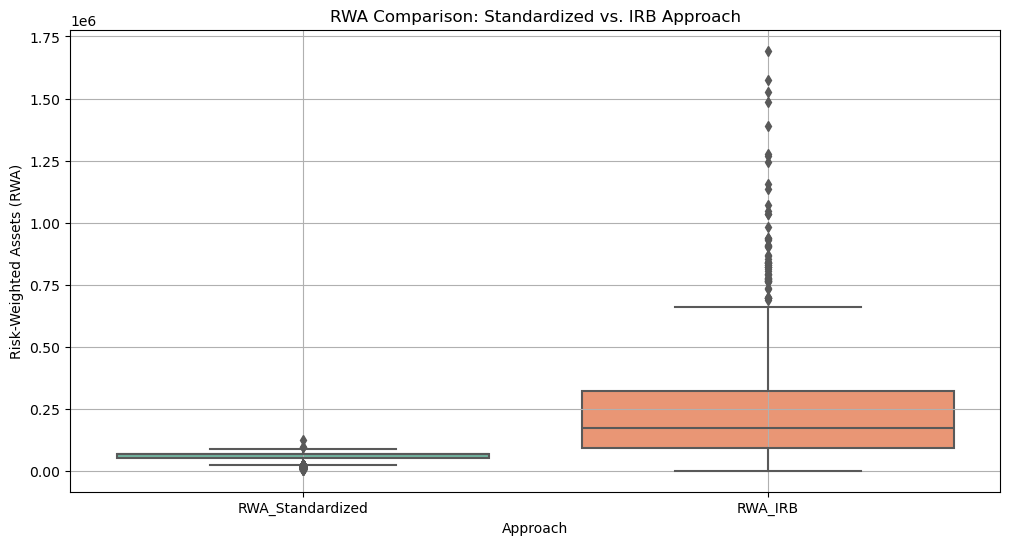

In [72]:
plt.figure(figsize=(12, 6))
data = defaulted_loans[['RWA_Standardized', 'RWA_IRB']].melt(var_name='Approach', value_name='RWA')
sns.boxplot(data=data, x='Approach', y='RWA', palette='Set2')
plt.title('RWA Comparison: Standardized vs. IRB Approach')
plt.xlabel('Approach')
plt.ylabel('Risk-Weighted Assets (RWA)')
plt.grid()
plt.show()

In [73]:
rwa_stats = non_defaulted_df[['RWA_Standardized', 'RWA_IRB']].describe()

# Display the statistics
print(rwa_stats)

       RWA_Standardized       RWA_IRB
count     174447.000000  1.744470e+05
mean       56343.865147  4.499670e+04
std        15240.246387  5.897948e+04
min          916.650000  1.262468e+01
25%        48764.250000  9.109866e+03
50%        65019.000000  2.596152e+04
75%        65019.000000  5.909301e+04
max       242111.000000  1.528637e+06


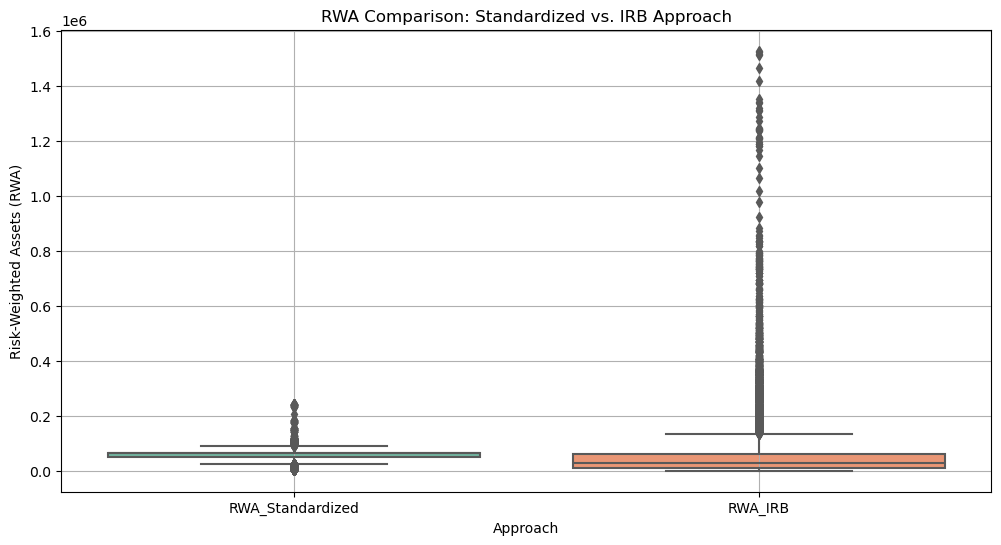

In [74]:
plt.figure(figsize=(12, 6))
data = non_defaulted_df[['RWA_Standardized', 'RWA_IRB']].melt(var_name='Approach', value_name='RWA')
sns.boxplot(data=data, x='Approach', y='RWA', palette='Set2')
plt.title('RWA Comparison: Standardized vs. IRB Approach')
plt.xlabel('Approach')
plt.ylabel('Risk-Weighted Assets (RWA)')
plt.grid()
plt.show()

### Overall Comparison

In [75]:
rwa_stats = df[['RWA_Standardized', 'RWA_IRB']].describe()

# Display the statistics
print(rwa_stats)

       RWA_Standardized       RWA_IRB
count     218497.000000  2.193620e+05
mean       56382.884213  7.548410e+04
std        15105.741928  9.774404e+04
min          916.650000  1.262468e+01
25%        48764.250000  1.278087e+04
50%        65019.000000  3.913759e+04
75%        65019.000000  9.141178e+04
max       242111.000000  1.693211e+06


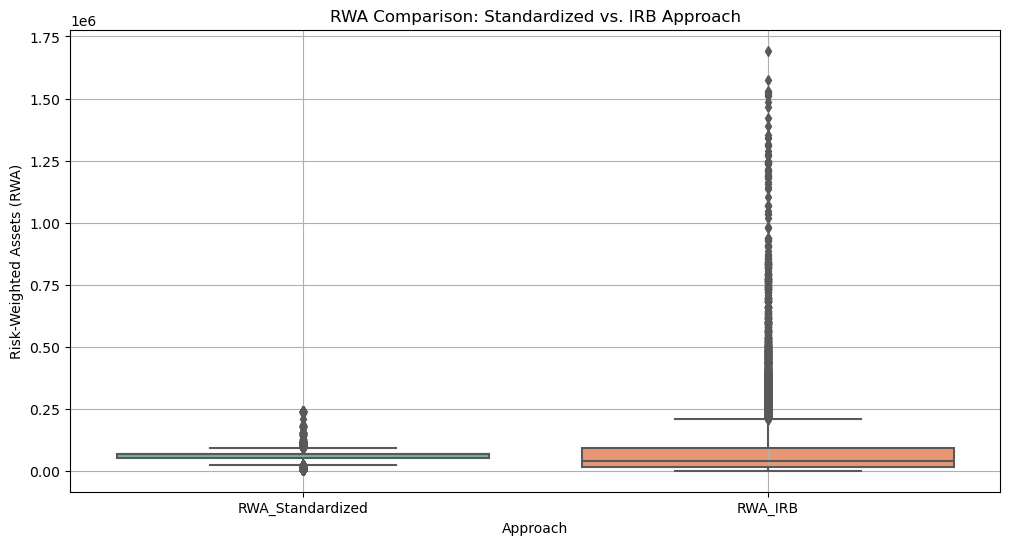

In [76]:
plt.figure(figsize=(12, 6))
data = df[['RWA_Standardized', 'RWA_IRB']].melt(var_name='Approach', value_name='RWA')
sns.boxplot(data=data, x='Approach', y='RWA', palette='Set2')
plt.title('RWA Comparison: Standardized vs. IRB Approach')
plt.xlabel('Approach')
plt.ylabel('Risk-Weighted Assets (RWA)')
plt.grid()
plt.show()

In [77]:
df

,BAD,MORTDUE,VALUE,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,...,PD,RWA_IRB,RWA_Defaulted,Maturity,RWA_IRB_with_M,RWA_Basel_Advanced,Capital_Standardized,Capital_IRB,Capital_IRB_with_M,Capital_Basel_Advanced
0,1,25860.0,39025.0,Other,10.5,0.0,0.0,94.366667,1.0,9.0,...,0.323797,47100.368094,35029.335300,2.5,NaN,111577.912239,NaN,3768.029447,NaN,8926.232979
1,1,70053.0,68400.0,Other,7.0,0.0,2.0,121.833333,0.0,14.0,...,0.910984,358971.564719,94892.112364,2.5,NaN,392472.537627,NaN,28717.725177,NaN,31397.803010
2,1,13500.0,16700.0,Other,4.0,0.0,0.0,149.466667,1.0,10.0,...,0.245535,18645.284037,18286.775968,2.5,NaN,52035.348993,NaN,1491.622723,NaN,4162.827919
3,1,65019.0,89526.0,Unknown,7.0,0.0,0.0,173.466667,1.0,20.0,...,0.196498,71865.540370,88073.176792,2.5,NaN,226804.864518,5201.520,5749.243230,NaN,18144.389161
4,1,65019.0,89526.0,Unknown,7.0,0.0,0.0,173.466667,1.0,20.0,...,0.196498,71865.540370,41379.587577,2.5,NaN,226804.864518,3901.140,5749.243230,NaN,18144.389161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219357,0,57264.0,90185.0,Other,16.0,0.0,0.0,221.808718,0.0,16.0,...,0.128221,41301.179812,NaN,2.5,44895.904981,161772.170302,2290.560,3304.094385,3591.672398,12941.773624
219358,0,54576.0,92937.0,Other,16.0,0.0,0.0,208.692070,0.0,15.0,...,0.133861,41093.968484,NaN,2.5,44591.834374,157673.678429,1528.128,3287.517479,3567.346750,12613.894274
219359,0,54045.0,92924.0,Other,15.0,0.0,0.0,212.279697,0.0,15.0,...,0.126208,38367.715186,NaN,2.5,41734.421554,151415.448213,1513.260,3069.417215,3338.753724,12113.235857
219360,0,50370.0,91861.0,Other,14.0,0.0,0.0,213.892709,0.0,16.0,...,0.109017,30887.791293,NaN,2.5,33806.920099,130431.421353,1410.360,2471.023303,2704.553608,10434.513708
